# KNN Classifier
The KNN classifier algorithm is used to classify a sample based on number of nearest neighbors.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from utils import shuffle, train_test_split, min_max_normalize, label_encoder, confusion_matrix, accuracy 

from utils.math_functions import euclidian_distance

from neighbors import KNNClassifier

In [2]:
np.random.seed(1234)

In [3]:
iris = pd.read_csv('./data/Iris.csv')

## Preparing the datasets

The first thing to do is to split de dataset in two subsets, the training and the test.

To simplify error metrics algorithms, the target variable, which is a categorical variable, will be transformed from string to integer.

After processing the data, it is necessary to divide the dataset into training and testing. 70% will be used for training and 30% for testing. 

It is necessary to separate the target variable from the other features of each set that forms x_train and y_train, x_test and y_test.

The algorithm performs distance calculations, so it is extremely necessary to normalize the data. For this problem, will be used the min-max normalization.

Note that the normalization function returns two values, which are the normalized dataset, and the values (min and max) used to normalize the data. if use the entire dataset, to generate the min and max values, will be 'cheating on the game'. Its needed to normalize test using min and max values of training set. This is also valid for new entries.

Min Max Normalization:

$\large {x}' = \frac{x - min(x)}{max(x) - min(x)}$

In [4]:
print('Before', [iris['Species'].iloc[0], iris['Species'].iloc[51], iris['Species'].iloc[125]])

iris['Species'], iris_labels = label_encoder(iris['Species'].values.tolist())

print('After', [iris['Species'].iloc[0], iris['Species'].iloc[51], iris['Species'].iloc[125]])

Before ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
After [0, 1, 2]


In [5]:
train, test = train_test_split(iris, train_size=0.7)

# Only for explanation proposal
original_train = train.copy(deep=True)

x_train = train.drop('Species', axis=1)
x_test = test.drop('Species', axis=1)

y_train = train['Species']
y_test = test['Species']

In [6]:
x_train, minmax = min_max_normalize(x_train)
x_test, _ = min_max_normalize(x_test)

It is possible to observe that, before normalizing, the features were at different scales, after normalizing the data, each feature was on the same scale (between zero and one). and without changing its characteristics.

<AxesSubplot:title={'center':'Normalized'}, xlabel='SepalLengthCm', ylabel='Count'>

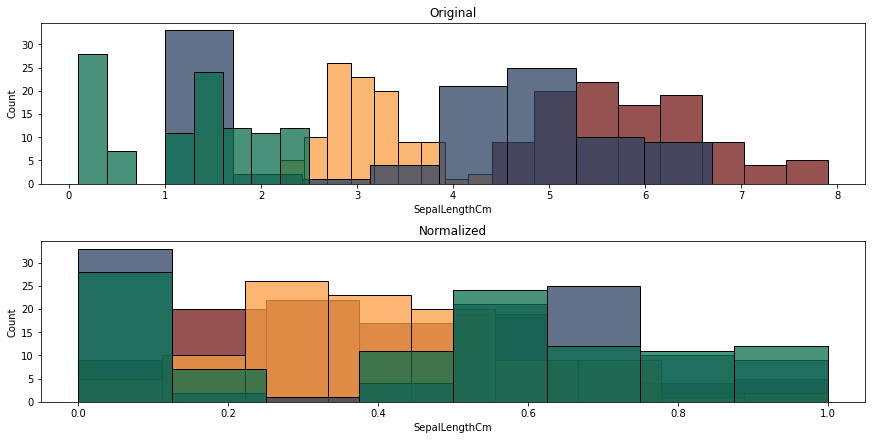

In [7]:
fig = plt.figure(figsize=(12,6), constrained_layout=True)
gs = GridSpec(2, 1, figure=fig)

original_ax = fig.add_subplot(gs[0,0], title='Original')
normalized_ax = fig.add_subplot(gs[1,0], title='Normalized')

sns.histplot(x=original_train['SepalLengthCm'], color='#721817', ax=original_ax)
sns.histplot(x=original_train['SepalWidthCm'], color='#fa9f42', ax=original_ax)
sns.histplot(x=original_train['PetalLengthCm'], color='#2b4162', ax=original_ax)
sns.histplot(x=original_train['PetalWidthCm'], color='#0b6e4f', ax=original_ax)

sns.histplot(x=x_train['SepalLengthCm'], color='#721817', ax=normalized_ax)
sns.histplot(x=x_train['SepalWidthCm'], color='#fa9f42', ax=normalized_ax)
sns.histplot(x=x_train['PetalLengthCm'], color='#2b4162', ax=normalized_ax)
sns.histplot(x=x_train['PetalWidthCm'], color='#0b6e4f', ax=normalized_ax)

## KNN explanation

In this session, the algorithm will be explained separately. It is recommended to see the full algorithm in neighbors/knn_classifier.py

## Train
The training of knn consists only to saving the training dataset. In this case, will be used ndarray from numpy. Will be needed to convert pd.DataFrame to np.array, since the dataset is in pd.DataFrame



In [8]:
k = 3 # always defined on class constructor
x = np.array(x_train.values.tolist())
y = np.array(y_train.values.tolist())

## Predict

To predict a sample, you must find the k nearest neighbors. The class that has the highest occurrence, is the class chosen for that sample. 

In example below, the class “A” is represented by red dots, and the class “B” is represented by yellow dots. The sample to predict is represented by blue dot and the k value used is 3. The three nearest neighbors are in the blue circle, so just count the amount of occurring. The circle has two occurrence of “A” and one of “B”, so, the class of sample is “A”

![knn_example](doc_imgs/knn_1.jpg)

The prediction consists of these steps
* Calculate distances between the sample and the training dataset
* Sort the distances ascending
* Select the k lowest distances
* Select the labels of each distances
* Count the occurrences of each label
* Select the most common label

In [9]:
# Sample to predict
sample = x_test.iloc[9].tolist()
y_sample = y_test.iloc[9].tolist()

In [10]:
# Distances between sample and train set
distances = euclidian_distance(sample, x)
distances

array([0.38782221, 0.47647711, 0.43583364, 1.10860759, 0.38683315,
       1.00193943, 1.05103749, 1.01291175, 0.28974206, 0.88028539,
       0.38452835, 0.99651969, 1.01034556, 0.44430758, 0.88692176,
       0.45855591, 0.61518689, 0.99830782, 0.55656677, 0.28015056,
       0.50697853, 0.57907018, 0.60620791, 0.46664785, 0.85200977,
       1.02066307, 0.39019246, 0.35910265, 0.68075445, 1.09121299,
       0.39122774, 0.36461589, 0.99798121, 0.43487745, 0.55399237,
       1.01719125, 1.09429967, 1.05152647, 1.13264203, 0.43695137,
       1.04575608, 0.5187385 , 1.17687314, 0.65167462, 0.72507295,
       1.10337775, 0.37142097, 0.60908836, 0.87901971, 0.64414438,
       1.11454481, 0.53497236, 0.85693392, 0.40570522, 0.53729732,
       0.42711864, 0.37523032, 0.69841364, 0.60886284, 1.07085998,
       0.99521915, 0.76169037, 0.27189062, 0.4981451 , 1.05695055,
       1.18901265, 1.16395669, 0.47133368, 0.59247944, 0.44599237,
       0.70381858, 0.46189061, 1.16122497, 0.43335973, 1.15070

In [11]:
# argsort retun the indices that sort the distance array 
index = np.argsort(distances)

# Select the k lowest distances index
k_best_index = index[:k]

# Select the labels of each distances
k_best = y[k_best_index]
k_best

array([1, 2, 2])

In [12]:
(labels, counts) = np.unique(k_best,return_counts=True)
index=np.argmax(counts)
print('real:', iris_labels[y_sample])
print('predict:', iris_labels[index])

real: Iris-virginica
predict: Iris-versicolor


# KNN Classifier Model

In [13]:
%%time
knn = KNNClassifier(k=3)
knn.fit(x_train, y_train)

y_pred = knn.predict(x_test)

Wall time: 2 ms


acc 100.00


Text(0.5, 15.0, 'real')

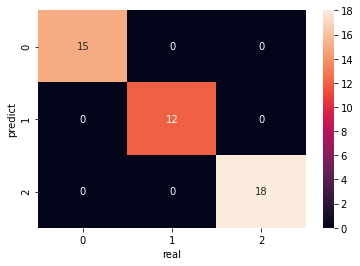

In [15]:
acc = accuracy(y_test, y_pred) * 100
conf = confusion_matrix(y_test, y_pred)
print('acc %.2f' % acc)
sns.heatmap(conf, annot=True)
plt.xlabel('predict')
plt.ylabel('real')